# Практическая работа 2

## Классификация

Выполнил: Самарин Никита Группа: КИ21-17/2Б

Цель: знакомство с теоретическими основами задачи классификации
объектов, формирование навыков решения задачи бинарной классификации с
помощью языка программирования Python.

Задачи:
Выполнение практической работы предполагает решение следующий
задач:
1. Предварительная обработку исходных данных
2. Обучение базовых моделей классификации
3. Подбор оптимальных параметров моделей классификации
4. Оценка качества построенных моделей на тестовой выборке

Вариант 3: Соревнование «Customer churn prediction»

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import warnings

import utilities2
import anomalies_found

In [134]:
cat_atributes = ['Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']
num_attributes = ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen']
r_class = 'Churn'
dataframe = pd.read_csv("kaggle/input/mso-churn/train.csv", usecols = cat_atributes + num_attributes + [r_class])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              3169 non-null   int64  
 1   MonthlySpending           3169 non-null   float64
 2   TotalSpent                3169 non-null   object 
 3   Sex                       3169 non-null   object 
 4   IsSeniorCitizen           3169 non-null   int64  
 5   HasPartner                3169 non-null   object 
 6   HasChild                  3169 non-null   object 
 7   HasPhoneService           3169 non-null   object 
 8   HasMultiplePhoneNumbers   3169 non-null   object 
 9   HasInternetService        3169 non-null   object 
 10  HasOnlineSecurityService  3169 non-null   object 
 11  HasOnlineBackup           3169 non-null   object 
 12  HasDeviceProtection       3169 non-null   object 
 13  HasTechSupportAccess      3169 non-null   object 
 14  HasOnlin

In [135]:
dataframe[num_attributes + [r_class]] = dataframe[num_attributes + [r_class]].apply(pd.to_numeric, errors="coerce")

In [136]:
for i in num_attributes[1:4]:
    dataframe = anomalies_found.sigma_method(dataframe, i)
dataframe = dataframe.reset_index(drop = True)

Границы для MonthlySpending -24.59354446444287 154.9089751996906
Границы для TotalSpent -4454.780891361648 8959.578867966136
Границы для IsSeniorCitizen -0.9442472354990956 1.2692709022709479


In [137]:
print(dataframe.isnull().sum())

ClientPeriod                0
MonthlySpending             0
TotalSpent                  6
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


In [138]:
dataframe = dataframe.fillna(dataframe['TotalSpent'].mean())

In [139]:
for i in cat_atributes:
    encoder = LabelEncoder()
    encoder_df = pd.DataFrame(encoder.fit_transform(dataframe[i]), columns=[i + "_encoded"])
    dataframe = pd.concat([encoder_df, dataframe], axis=1, join='inner')
    print("Полученные кодировки для", i, {l: i for i, l in enumerate(encoder.classes_)})

scaler = MinMaxScaler()
for i in num_attributes:
    numeric_dataframe = dataframe[[i]]
    numeric_dataframe = scaler.fit_transform(numeric_dataframe)
    dataframe[i + "_norm"] = numeric_dataframe
dataframe.drop(cat_atributes, axis = 'columns', inplace = True)
dataframe.drop(num_attributes, axis = 'columns', inplace = True)
dataframe.columns = dataframe.columns.str.replace('_norm', '')
dataframe.columns = dataframe.columns.str.replace('_encoded', '')
dataframe = dataframe[cat_atributes + num_attributes + [r_class]]
dataframe.head()

Полученные кодировки для Sex {'Female': 0, 'Male': 1}
Полученные кодировки для HasPartner {'No': 0, 'Yes': 1}
Полученные кодировки для HasChild {'No': 0, 'Yes': 1}
Полученные кодировки для HasPhoneService {'No': 0, 'Yes': 1}
Полученные кодировки для HasMultiplePhoneNumbers {'No': 0, 'No phone service': 1, 'Yes': 2}
Полученные кодировки для HasInternetService {'DSL': 0, 'Fiber optic': 1, 'No': 2}
Полученные кодировки для HasOnlineSecurityService {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasOnlineBackup {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasDeviceProtection {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasTechSupportAccess {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasOnlineTV {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasMovieSubscription {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasContractPhone {'Month-to-month':

,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
0,1,1,1,1,0,2,1,1,1,1,1,1,2,1,1,0.388889,0.020418,0.054126,0.0,0
1,1,0,0,1,0,1,0,0,0,0,2,0,0,1,2,0.166667,0.629482,0.103059,0.0,0
2,1,0,0,1,0,2,1,1,1,1,1,1,0,1,3,0.347222,0.018924,0.059711,0.0,0
3,1,0,0,1,2,0,0,0,2,2,0,2,2,0,0,0.694444,0.510458,0.392262,0.0,0
4,0,1,0,1,2,1,0,0,0,2,2,2,0,1,2,0.541667,0.826693,0.453531,1.0,0


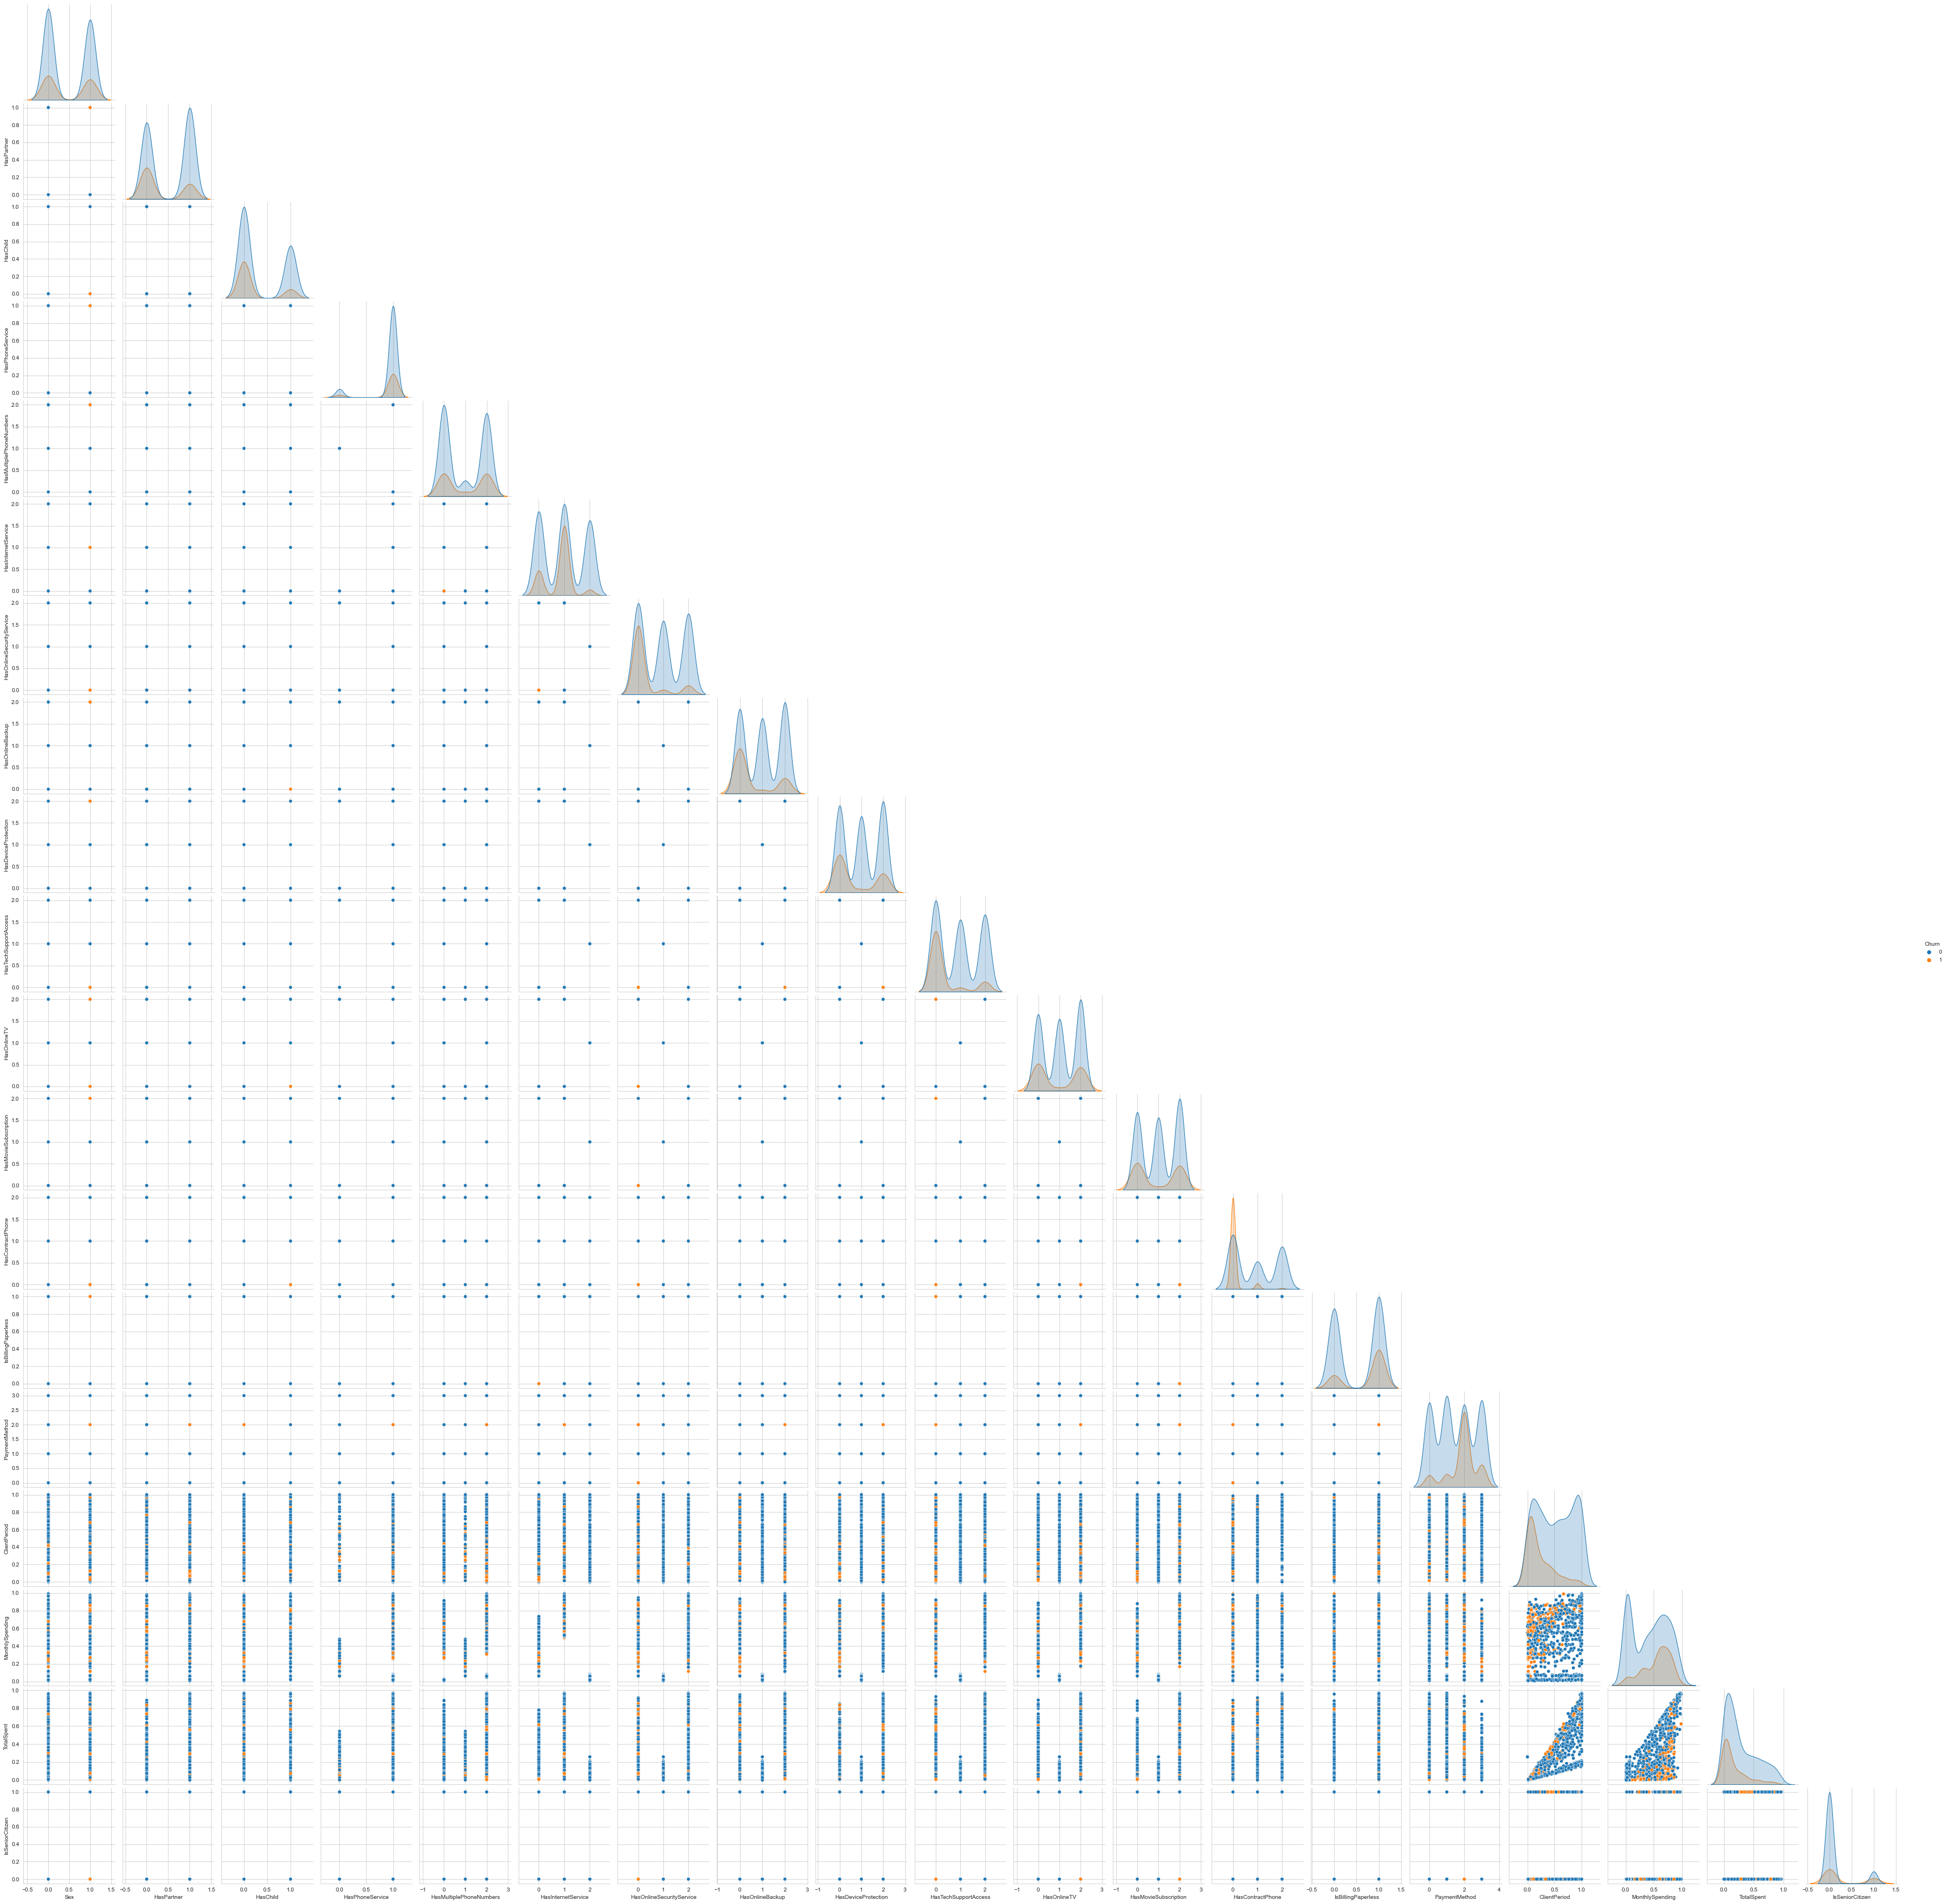

In [140]:
sns.pairplot(dataframe.sample(n=1000), corner=True, hue = 'Churn')

## Отбор информативных признаков

In [141]:
dataframe_X = dataframe.iloc[:, 0:19]
dataframe_y = dataframe[r_class]
labels = []
scores = []

Без отбора

In [142]:
_, score_filtr = utilities2.inf_atr(None, dataframe_X, dataframe_y)
labels.append("Without")
scores.append(score_filtr // 0.0001 / 10000)
score_filtr // 0.0001 / 10000

0.8137

Метод фильтрации

In [143]:
selector = SelectKBest(f_classif)
features_filtr, score_filtr = utilities2.inf_atr(selector, dataframe_X, dataframe_y)
labels.append("filtr")
scores.append(score_filtr // 0.0001 / 10000)
features_filtr, score_filtr // 0.0001 / 10000

(Index(['HasChild', 'HasOnlineSecurityService', 'HasOnlineBackup',
        'HasDeviceProtection', 'HasTechSupportAccess', 'HasContractPhone',
        'IsBillingPaperless', 'ClientPeriod', 'MonthlySpending', 'TotalSpent'],
       dtype='object'),
 0.818)

Обёрточный метод

In [144]:
selector = SequentialFeatureSelector(GaussianNB(), n_features_to_select='auto')
selector.fit(dataframe_X, dataframe_y)
cols = dataframe_X.columns[selector.get_support()].tolist()

features_obert, score_obert = utilities2.inf_atr(None, dataframe_X, dataframe_y, cols=cols)
labels.append("obert")
scores.append(score_obert // 0.0001 / 10000)
features_obert, score_obert // 0.0001 / 10000

(['Sex',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineTV',
  'HasMovieSubscription',
  'ClientPeriod',
  'MonthlySpending',
  'IsSeniorCitizen'],
 0.8137)

Встроенный метод

In [145]:
lasso = LassoCV()
lasso.fit(dataframe_X, dataframe_y)
cols = dataframe_X.columns[lasso.coef_ != 0].tolist()

features_inb, score_inb = utilities2.inf_atr(None, dataframe_X, dataframe_y, cols=cols)
labels.append("inb")
scores.append(score_inb // 0.0001 / 10000)
features_inb, score_inb // 0.0001 / 10000

(['Sex',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod',
  'ClientPeriod',
  'MonthlySpending',
  'TotalSpent',
  'IsSeniorCitizen'],
 0.8137)

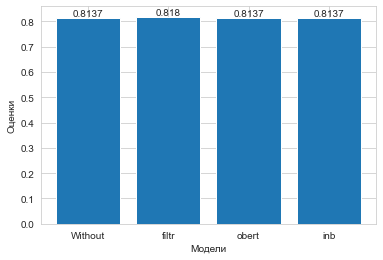

In [146]:
utilities2.build_bar_plot(labels, scores)

Выберем обёрточный метод

In [147]:
features = features_obert
dataframe_X = dataframe[list(features)]
dataframe_y = dataframe[r_class]
dataframe_X

,Sex,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineTV,HasMovieSubscription,ClientPeriod,MonthlySpending,IsSeniorCitizen
0,1,1,0,2,1,1,0.388889,0.020418,0.0
1,1,1,0,1,2,0,0.166667,0.629482,0.0
2,1,1,0,2,1,1,0.347222,0.018924,0.0
3,1,1,2,0,0,2,0.694444,0.510458,0.0
4,0,1,2,1,2,2,0.541667,0.826693,1.0
...,...,...,...,...,...,...,...,...,...
3164,1,1,0,1,2,0,0.027778,0.614542,0.0
3165,1,1,2,1,0,0,0.222222,0.553785,0.0
3166,1,1,2,0,2,0,0.694444,0.518924,1.0
3167,1,1,2,0,0,0,0.750000,0.366036,0.0


## Сэмплирование

До сэмплирования

0.7685


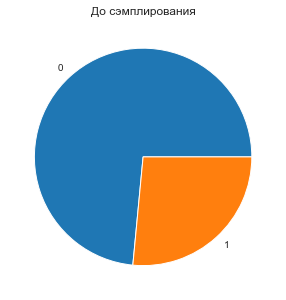

In [148]:
labels = []
scores = []

count = dataframe_y.value_counts()
figure = plt.figure(figsize=(25, 5))
ax_1 = figure.add_subplot(1, 2, 1)
ax_1.set_title('До сэмплирования')
ax_1.pie(count.values, labels = count.index)

X_train, X_test, y_train, y_test = train_test_split(dataframe_X, dataframe_y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:, 1])
print(score // 0.0001 / 10000)
labels.append("Without")
scores.append(score // 0.0001 / 10000)

Оверсэмплинг

0.7997


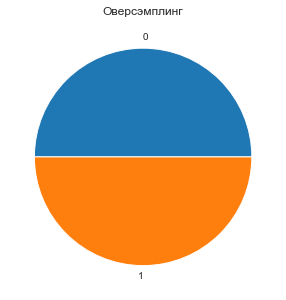

In [149]:
dataframe_X_ov, dataframe_y_ov, score = utilities2.sampling(SMOTE(), dataframe_X, dataframe_y, 'Оверсэмплинг')
labels.append("Over")
scores.append(score // 0.0001 / 10000)

Андерсэмплинг

0.9475


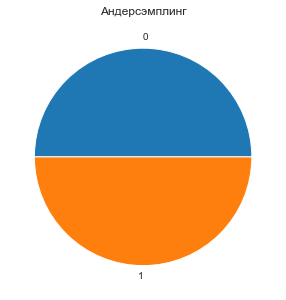

In [150]:
dataframe_X_un, dataframe_y_un, score = utilities2.sampling(NearMiss(version=2), dataframe_X, dataframe_y, 'Андерсэмплинг')
labels.append("Under")
scores.append(score // 0.0001 / 10000)

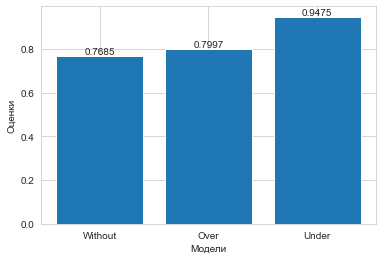

In [151]:
utilities2.build_bar_plot(labels, scores)

Андерсэмплинг лучше

In [152]:
dataframe_X = dataframe_X_un
dataframe_y = dataframe_y_un

## Построение моделей классификации

In [153]:
X_train, X_test, y_train, y_test = train_test_split(dataframe_X, dataframe_y, test_size=0.3, random_state=0)
X_test.head()
labels = []
scores = []
models = []

### Логистическая регрессия

Tuned hpyerparameters (best parameters): {'penalty': 'none'}
Train accuracy: 0.9661
Test accuracy: 0.9027


<Axes: xlabel='C', ylabel='score'>

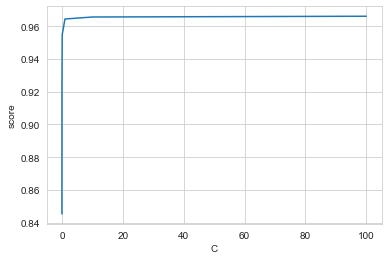

In [154]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
warnings.filterwarnings('ignore')
logreg = LogisticRegression()
cv = utilities2.grid_search(logreg, parameters, X_train, X_test, y_train, y_test)
cv_df = pd.DataFrame(cv.cv_results_['params'])
cv_df['score'] = cv.cv_results_['mean_test_score']
sns.lineplot(data=cv_df, x='C', y='score')

In [155]:
logreg = cv

y_pred = logreg.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:,1])
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(score))
labels.append("LR")
scores.append(score // 0.0001 / 10000)
y_train_pr, y_test_pr = cv.predict_proba(X_train)[:, 1], cv.predict_proba(X_test)[:, 1]
models.append(logreg)

Accuracy of logistic regression classifier on test set: 0.9541


### Метод ближайших соседей

Tuned hpyerparameters (best parameters): {'algorithm': 'ball_tree', 'n_neighbors': 13, 'weights': 'uniform'}
Train accuracy: 0.9638
Test accuracy: 0.9107


<Axes: xlabel='n_neighbors', ylabel='score'>

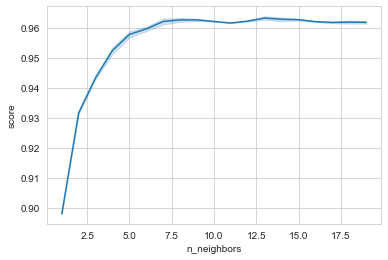

In [156]:
parameters = {'n_neighbors': list(range(1, 20)),
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree']}
knn = KNeighborsClassifier()
cv = utilities2.grid_search(knn, parameters, X_train, X_test, y_train, y_test)
cv_df = pd.DataFrame(cv.cv_results_['params'])
cv_df['score'] = cv.cv_results_['mean_test_score']
sns.lineplot(data=cv_df, x='n_neighbors', y='score')

In [157]:
kneighbors = cv

y_pred = kneighbors.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:,1])
print('Accuracy of KNeighborsClassifier on test set: {:.4f}'.format(score))
labels.append("KNC")
scores.append(score // 0.0001 / 10000)
models.append(kneighbors)

Accuracy of KNeighborsClassifier on test set: 0.9625


### Наивный байесовский классификатор

In [158]:
parameters = {}
gnb = GaussianNB()
cv = utilities2.grid_search(gnb, parameters, X_train, X_test, y_train, y_test)

Tuned hpyerparameters (best parameters): {}
Train accuracy: 0.9387
Test accuracy: 0.8888


In [159]:
gnb = cv

y_pred = gnb.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:,1])
print('Accuracy of GaussianNB classifier on test set: {:.4f}'.format(score))
labels.append("GNB")
scores.append(score // 0.0001 / 10000)
models.append(gnb)

Accuracy of GaussianNB classifier on test set: 0.9371


### Линейный дискриминантный анализ

In [160]:
parameters = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': ['auto', None]
}
lda = LinearDiscriminantAnalysis()
cv = utilities2.grid_search(lda, parameters, X_train, X_test, y_train, y_test)

Tuned hpyerparameters (best parameters): {'shrinkage': None, 'solver': 'lsqr'}
Train accuracy: 0.9597
Test accuracy: 0.8908


In [161]:
lda = cv

y_pred = lda.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:,1])
print('Accuracy of LinearDiscriminantAnalysis classifier on test set: {:.4f}'.format(score))
labels.append("LDA")
scores.append(score // 0.0001 / 10000)
models.append(lda)

Accuracy of LinearDiscriminantAnalysis classifier on test set: 0.9538


### Квадратичный дискриминантный анализ

In [162]:
parameters = {}
qda = QuadraticDiscriminantAnalysis()
cv = utilities2.grid_search(qda, parameters, X_train, X_test, y_train, y_test)

Tuned hpyerparameters (best parameters): {}
Train accuracy: 0.9567
Test accuracy: 0.8908


In [163]:
qda = cv

y_pred = qda.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:,1])
print('Accuracy of QuadraticDiscriminantAnalysis classifier on test set: {:.4f}'.format(score))
labels.append("QDA")
scores.append(score // 0.0001 / 10000)
models.append(qda)

Accuracy of QuadraticDiscriminantAnalysis classifier on test set: 0.9575


### Метод опорных векторов

In [164]:
parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
svm = SVC(probability=True)
cv = utilities2.grid_search(svm, parameters, X_train, X_test, y_train, y_test)

Tuned hpyerparameters (best parameters): {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Train accuracy: 0.9648
Test accuracy: 0.8968


In [165]:
svc = cv
y_pred = svc.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred[:,1])
print('Accuracy of SVM on test set: {:.4f}'.format(score))
labels.append("SVM")
scores.append(score // 0.0001 / 10000)
models.append(svc)

Accuracy of SVM on test set: 0.9561


## Сравним модели

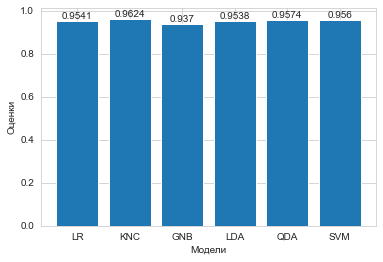

In [166]:
utilities2.build_bar_plot(labels, scores)

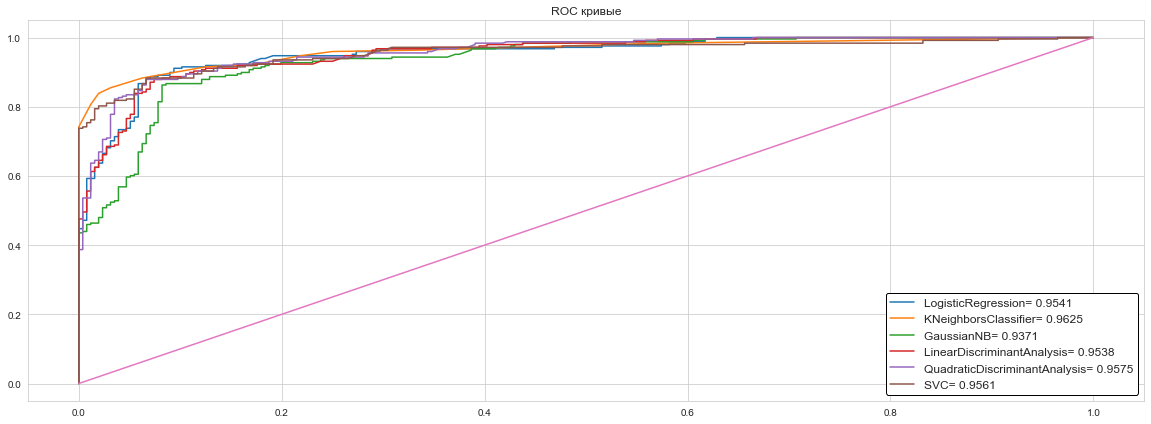

In [167]:
utilities2.roc_auc_plot(models, X_test, y_test)

In [168]:
model = qda

## Классифицируем тестовую выборку

In [169]:
test_dataframe = pd.read_csv("kaggle/input/mso-churn/test.csv", usecols = num_attributes + cat_atributes)
id_dataframe = pd.read_csv("kaggle/input/mso-churn/test.csv", usecols = ["id"])
print(features)
print(num_attributes)
print(cat_atributes)
test_dataframe.head()

['Sex', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineTV', 'HasMovieSubscription', 'ClientPeriod', 'MonthlySpending', 'IsSeniorCitizen']
['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen']
['Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,46,55.65,2688.85,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,Yes,One year,No,Credit card (automatic)
1,48,78.75,3682.45,Male,0,No,Yes,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
2,7,69.20,477.55,Female,0,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic)
3,3,75.15,216.75,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
4,14,19.35,324.8,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check


In [170]:
test_dataframe[num_attributes] = test_dataframe[num_attributes].apply(pd.to_numeric, errors="coerce")

In [171]:
test_dataframe[test_dataframe.isnull().any(1)]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
174,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
1261,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic)
2085,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic)


In [172]:
test_dataframe = test_dataframe.fillna(0)

In [173]:
for i in cat_atributes:
    encoder = LabelEncoder()
    encoder_df = pd.DataFrame(encoder.fit_transform(test_dataframe[i]), columns=[i + "_encoded"])
    test_dataframe = pd.concat([encoder_df, test_dataframe], axis=1, join='inner')
    print("Полученные кодировки для", i, {l: i for i, l in enumerate(encoder.classes_)})

for i in num_attributes:
    scaler = MinMaxScaler()
    numeric_dataframe = test_dataframe[[i]]
    numeric_dataframe = scaler.fit_transform(numeric_dataframe)
    test_dataframe[i + "_norm"] = numeric_dataframe
test_dataframe.drop(cat_atributes, axis = 'columns', inplace = True)
test_dataframe.drop(num_attributes, axis = 'columns', inplace = True)
test_dataframe.columns = test_dataframe.columns.str.replace('_norm', '')
test_dataframe.columns = test_dataframe.columns.str.replace('_encoded', '')
test_dataframe = test_dataframe[cat_atributes + num_attributes]

Полученные кодировки для Sex {'Female': 0, 'Male': 1}
Полученные кодировки для HasPartner {'No': 0, 'Yes': 1}
Полученные кодировки для HasChild {'No': 0, 'Yes': 1}
Полученные кодировки для HasPhoneService {'No': 0, 'Yes': 1}
Полученные кодировки для HasMultiplePhoneNumbers {'No': 0, 'No phone service': 1, 'Yes': 2}
Полученные кодировки для HasInternetService {'DSL': 0, 'Fiber optic': 1, 'No': 2}
Полученные кодировки для HasOnlineSecurityService {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasOnlineBackup {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasDeviceProtection {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasTechSupportAccess {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasOnlineTV {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasMovieSubscription {'No': 0, 'No internet service': 1, 'Yes': 2}
Полученные кодировки для HasContractPhone {'Month-to-month':

In [174]:
test_dataframe = test_dataframe[features]
y_pred = model.predict_proba(test_dataframe)
y_pred[:,1]

array([1.        , 1.        , 0.9999912 , ..., 1.        , 0.99999991,
       1.        ])

In [175]:
result_df = pd.DataFrame(y_pred[:,1], columns=["churn"])
result_df =  pd.concat([id_dataframe, result_df], axis=1, join='inner')
result_df

,id,churn
0,2258,1.000000
1,3864,1.000000
2,1391,0.999991
3,486,0.999937
4,970,0.000040
...,...,...
2108,1700,1.000000
2109,1865,1.000000
2110,478,1.000000
2111,1227,1.000000


In [176]:
result_df.to_csv("kaggle/working/submission.csv", index=False)